# Analysis of Reddit Comments on Climate Change
This notebook analyzes Reddit comments on climate change. Our team's goal is to: ...

SENG 550 Final Project
- Monmoy Maahdie
- Smitkumar Saraiya
- Farhan Ali
- Kai Ferrer

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
from collections import Counter
from pyspark.sql.functions import col, length, regexp_replace, udf, split, explode
from pyspark.sql.types import DoubleType, StringType, IntegerType

In [2]:

from pyspark.ml.feature import Tokenizer, HashingTF, VectorAssembler, StopWordsRemover
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import from_unixtime

## 2. Create Spark Session

In [3]:
# Initialize spark session
spark = SparkSession.builder \
    .appName("Reddit Climate Change Comments") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

24/12/19 17:01:46 WARN Utils: Your hostname, Yeontan.local resolves to a loopback address: 127.0.0.1; using 192.168.1.69 instead (on interface en0)
24/12/19 17:01:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/19 17:01:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/19 17:01:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/19 17:01:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## 3. Load Data

In [4]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
len(stopwords)

326

## 4. Data Cleaning

In [5]:
nlp.Defaults.stop_words -= {"no", "not"}

In [6]:
# Create dataframe
df = spark.read.csv("the-reddit-climate-change-dataset-comments.csv", header=True, inferSchema=True)
df = df.repartition(100)  #  increase the number of partitions for large dataset
# df.show(5, truncate=False) # checking the dataset by displaying first 5 rows
df_original = df # save original dataset

In [7]:
new_columns = [col_name.replace('.', '_') for col_name in df.columns]
df = df.toDF(*new_columns)
# df.show(5, truncate=False)

In [8]:
df_clean = df.dropna()
# df_clean.show(n=5, truncate=False)

In [9]:
df_clean = df_clean.drop("permalink")

# Separate records where sentiment and score can be cast to numbers
clean_df = df_clean.filter(
    col("sentiment").cast(DoubleType()).isNotNull() &
    col("score").cast(DoubleType()).isNotNull()
)

# Records where either sentiment or score contain non-numerical values
problematic_df = df_clean.filter(
    col("sentiment").cast(DoubleType()).isNull() |
    col("score").cast(DoubleType()).isNull()
)


In [10]:
# clean_df.filter((df_clean["type"] == "comment") & (df_clean["subreddit_name"] == "technology")).show(n=100, truncate=False) | YOU CAN MIDIFY THE SUBREDDIT NAME TO SEE CLIMATE CHANGE DISCUSSIONS ON DIFFERENT SUBREDDITS
# clean_df.show(n=10, truncate=False) # we want this data

In [11]:
# print(clean_df.count())

In [12]:
# problematic_df.filter(df_clean["type"] == "comment").show(n=5, truncate=False) # this we do not need

## 4. Data Transformation
We start off by tokenizing the data using a spaCy model.
Then, we apply transformations to process the text.

In [13]:
clean_df_1 = clean_df.filter(col("type") == "comment") # only comments exist in here
# clean_df_1.show(n=10, truncate=False)

In [14]:
# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Define the preprocessing function
def preprocess(comment):
    doc = nlp(comment)
    processed_words_list = []
    for token in doc:
        if not token.is_punct and not token.like_url and not token.is_stop:
            processed_words_list.append(token.lemma_.strip().lower())
    return ' '.join(processed_words_list)

    
# Create a UDF from the function
preprocess_udf = udf(preprocess, StringType())


In [15]:
# Apply the UDF to create a new column
clean_df_2 = clean_df_1.withColumn('processed_body', preprocess_udf(col('body')))
clean_df_2.show(n=5, truncate=False)

+-------+-------+------------+--------------------+--------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|type   |id     |subreddit

Now, we are categorizing sentiments across 3 classes: negative, neutral, and positive sentiments. This is a necessary step as part of data transformation.

In [16]:
def create_label(sentiment):
    if float(sentiment) < -0.05:
        return -1
    elif float(sentiment) >= -0.05 and float(sentiment) <= 0.05:
        return 0
    else:
        return 1

create_label_udf = udf(create_label, IntegerType())


In [17]:
clean_df_3 = clean_df_2.withColumn('label', create_label_udf(col('sentiment')))
# Count occurrences of each subreddit_name and order by count in descending order
subreddit_counts = clean_df_3.groupBy('subreddit_name') \
    .count() \
    .orderBy('count', ascending=False)

# Show the results


In [18]:
# print("Most common subreddits:")
# subreddit_counts.show(10, truncate=False)

In [19]:
# # If you need the total number of unique subreddits
# unique_subreddits = subreddit_counts.count()
# print(f"\nTotal number of unique subreddits: {unique_subreddits}")

In [20]:
# subreddit_counts.filter(subreddit_counts['subreddit_name'] == 'climate').show()
clean_df_3 = clean_df_3.withColumn("sentiment", col("sentiment").cast(DoubleType()))


In [21]:

# print("At tokenizer")
# # Tokenize comment text
# tokenizer = Tokenizer(inputCol="processed_body", outputCol="words")

# # Transform words into numerical features
# print("At hashingTF")
# hashingTF = HashingTF(inputCol="words", outputCol="features", numFeatures=10000)

# # Define the model
# print("At linear regression")
# lr = LinearRegression(featuresCol="features", labelCol="sentiment")

# # Create a pipeline
# print("At pipeline")
# pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# # Split the data
# print("Data split")
# (train_data, test_data) = clean_df_3.randomSplit([0.01, 0.01])

# # Train the model
# print("model traiing")
# model = pipeline.fit(train_data)

# # Make predictions
# print("Predictions")
# predictions = model.transform(test_data)

# # Evaluate the model
# print("Mordel eval")
# evaluator = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="rmse")
# rmse = evaluator.evaluate(predictions)
# print("Root Mean Squared Error (RMSE) on test data =", rmse)


## 5. Data Analysis & Visualization

In [22]:
clean_df_3.show(5, truncate=False)

+-------+-------+------------+--------------------+--------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|type   |id     |sub

+-----+------+
|label| count|
+-----+------+
|   -1|810803|
|    1|718891|
|    0|265984|
+-----+------+



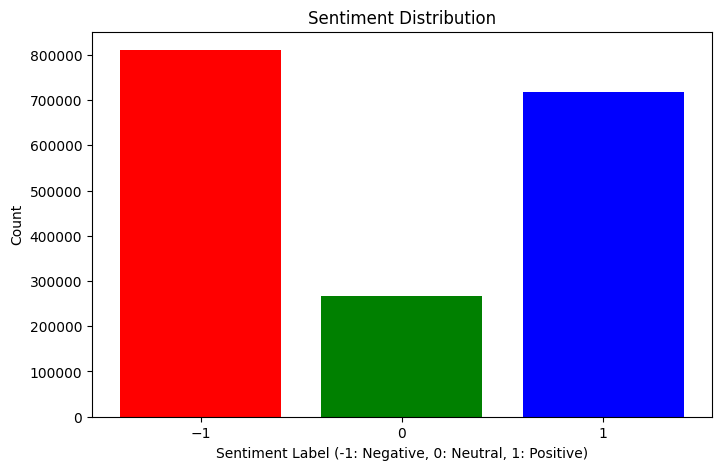

In [23]:
# Distribution of sentiment
sentiment_distribution = clean_df_3.groupBy('label').count() # Aggregation
sentiment_distribution.show()

sentiment_pd = sentiment_distribution.toPandas() #convert to pandas

# Graph
plt.figure(figsize=(8, 5))
plt.bar(sentiment_pd['label'], sentiment_pd['count'], color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.xticks(sentiment_pd['label'])
plt.show()

+----------------+------+
|  subreddit_name| count|
+----------------+------+
|        politics|145772|
|       worldnews|144551|
|       askreddit|130012|
|            news| 41375|
|      futurology| 35667|
|        collapse| 32603|
|         science| 28434|
|     environment| 28275|
|          canada| 23382|
|unpopularopinion| 22134|
+----------------+------+
only showing top 10 rows



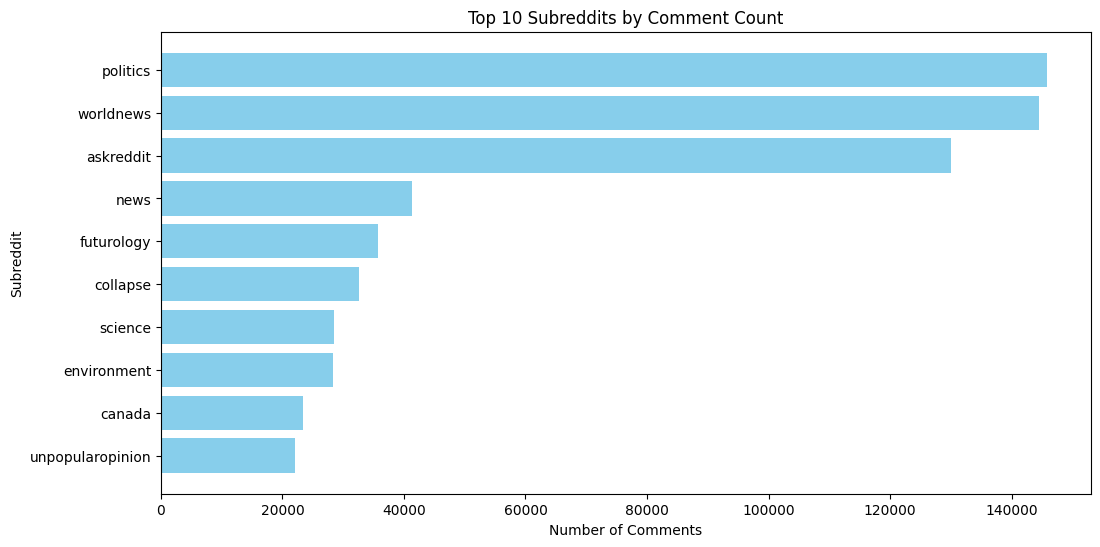

In [24]:
# Top Subreddits by Comments
# Group by subreddit_name and count occurrences
subreddit_counts = clean_df_3.groupBy('subreddit_name').count().orderBy('count', ascending=False)
subreddit_counts.show(10)
subreddit_pd = subreddit_counts.limit(10).toPandas()

# Graph
plt.figure(figsize=(12, 6))
plt.barh(subreddit_pd['subreddit_name'], subreddit_pd['count'], color='skyblue')
plt.title('Top 10 Subreddits by Comment Count')
plt.xlabel('Number of Comments')
plt.ylabel('Subreddit')
plt.gca().invert_yaxis()
plt.show()

+----------+--------------------+
|      date|   average_sentiment|
+----------+--------------------+
|2010-01-01| 0.17413333333333333|
|2010-01-02|-0.07739999999999995|
|2010-01-03|-0.00992499999999999|
|2010-01-04| -0.1606214285714286|
|2010-01-05| 0.09641071428571431|
|2010-01-06|              0.1572|
|2010-01-07| 0.06172857142857143|
|2010-01-08|-0.21251428571428568|
|2010-01-09| 0.13736428571428566|
|2010-01-10| 0.11970666666666667|
|2010-01-11|0.024036842105263172|
|2010-01-12|-0.20530769230769227|
|2010-01-13|            -0.31112|
|2010-01-14| 0.09243428571428575|
|2010-01-15| -0.1465866666666667|
|2010-01-16|-0.08733749999999998|
|2010-01-17| 0.14444545454545457|
|2010-01-18|-0.05638888888888...|
|2010-01-19| -0.0295888888888889|
|2010-01-20|-0.18011818181818182|
+----------+--------------------+
only showing top 20 rows



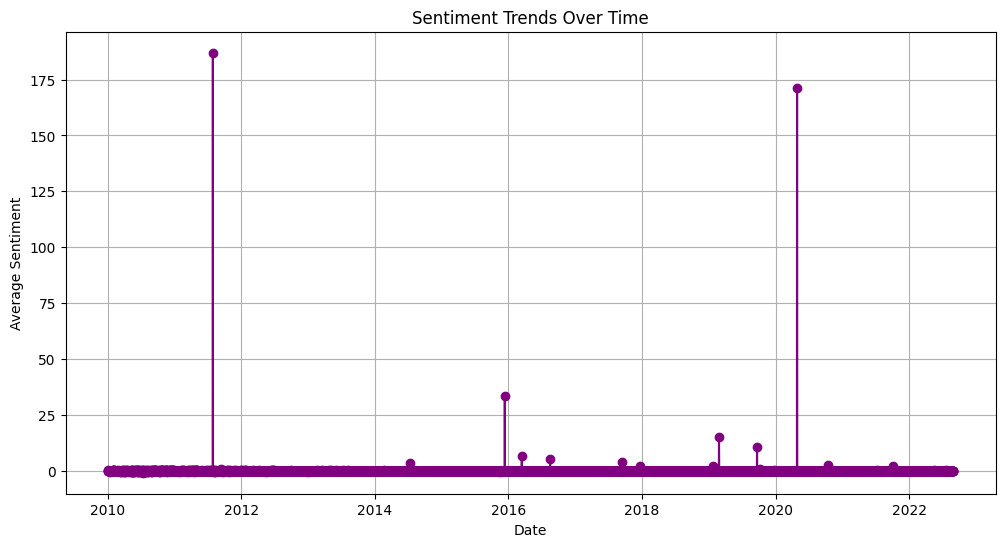

In [26]:
# Sentiment over time
# Ensure created_utc is cast to long
clean_df_3 = clean_df_3.withColumn("created_utc", col("created_utc").cast("long"))

# Convert created_utc to a date column
def convert_to_date(timestamp):
    return pd.to_datetime(timestamp, unit='s').strftime('%Y-%m-%d')

convert_to_date_udf = udf(convert_to_date, StringType())
clean_df_3 = clean_df_3.withColumn('date', convert_to_date_udf(col('created_utc')))

# Group by date and calculate average sentiment
sentiment_trends = clean_df_3.groupBy('date').agg({'sentiment': 'mean'}).orderBy('date')
sentiment_trends = sentiment_trends.withColumnRenamed('avg(sentiment)', 'average_sentiment')
sentiment_trends.show()

# Convert to Pandas for visualization
trends_pd = sentiment_trends.toPandas()
trends_pd['date'] = pd.to_datetime(trends_pd['date'])

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(trends_pd['date'], trends_pd['average_sentiment'], color='purple', marker='o')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


In [ ]:
spark.stop()